In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

#from sim_handling import Simulation,loadSim #uses ds7
from sim_handling2 import Simulation,loadSim #ds8: faster, more space efficient
from diffusionstuff8 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [4]:
%matplotlib widget

#set figsize to be big (12,12) inches
#rcParams['figure.figsize'] = 10,10

assymettric 2d growth

In [5]:
#load a simulation

#load the ablation with initial noise run
#test_2d_asym = loadSim('f2d_simulation_asymmetric250_200_500layers_center_reduction0.1_D_2_RK45_sigmamax_-0.01noisyinit_True.pkl')

#load the growth with initial noise run
#test_2d_asym = loadSim('f2d_simulation_asymmetric250_200_500layers_center_reduction0.1_D_2_RK45_sigmamax_0.2noisyinit_True.pkl')


In [6]:
#set up and run and plot a new simulation
test_2d_asym = Simulation(f2d, (250,300), method='RK45')

#try a noisy simulation
test_2d_asym.noisy_init = False

#test_2d_asym.float_params['DoverdeltaX2'] *= 2 
test_2d_asym.layermax = 300
#test_2d_asym.sigmastepmax= -0.01 #ablation
test_2d_asym.sigmastepmax= 0.20 #growth
test_2d_asym.center_reduction = 0.1
test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

In [7]:
my_id=['asymmetric'+str(test_2d_asym.shape[0])+'_'+str(test_2d_asym.shape[1]),str(test_2d_asym.layermax)+'layers',
                                'center_reduction'+str(test_2d_asym.center_reduction),  'D_2', test_2d_asym.method, 'sigmamax_'+str(test_2d_asym.sigmastepmax) +'noisyinit_'+str(test_2d_asym.noisy_init)] #'Cy_0_Dy0',
my_filename = ''.join([i+'_' for i in my_id])

In [8]:
#calcs to graph asymmetric sigmastep2d
xs,ys = test_2d_asym.x, test_2d_asym.y #linspace
sigma = getsigmastep_2d(xs,ys, test_2d_asym.center_reduction, test_2d_asym.sigmastepmax)
ygrid,xgrid = np.meshgrid(ys,xs) #2d mesh for plotting

In [ ]:
#countour plot of sigmastep 2d
print(xs.shape,ys.shape,sigma.shape)
fig,ax = plt.subplots()
CS = ax.contourf(xgrid,ygrid,sigma*100,np.arange(np.min(sigma*100)-0.01,np.max(sigma*100)+0.01,0.01))
#CS = ax.contourf(xgrid,ygrid,xgrid) #graph x
#CS = ax.contourf(xgrid,ygrid,ygrid) #graph y
ax.set_xlabel(r'$x (\mu m)$', fontsize=20)
ax.set_ylabel(r'$y (\mu m)$', fontsize=20)
plt.grid(True)
plt.gca().set_aspect('equal')
fig.colorbar(CS)
plt.title('%supersaturation (getsigmastep_2d)')
print(xgrid.shape,ygrid.shape)

In [ ]:
#animate the simulation (runs if needed)
#test_2d_asym.run(halve_time_res=True) #only saves half the time steps since it is a huge simulation

anim = test_2d_asym.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

In [ ]:
#start a second simulation starting with the ending surface of the first 
# as the initial surface

#create 1d sim and graph number of steps over time
cycle_sim =  Simulation(f2d, (test_2d_asym.shape[0],test_2d_asym.shape[1]), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

#keep general params same
cycle_sim.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
cycle_sim.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
cycle_sim.sigma0 = test_2d_asym.sigma0
cycle_sim.center_reduction = test_2d_asym.center_reduction
cycle_sim.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
cycle_sim.noisy_init = test_2d_asym.noisy_init

#set up initial surface
cycle_sim.nonstd_init = True
ntots = test_2d_asym.getNtot()
cycle_sim.startingNtot = ntots[len(ntots)//2] #start with the middle of the last simulation, before discretzation error

#set to ablation run
cycle_sim.sigmastepmax = -0.01


In [ ]:
#animate ablation of growth ending surface
anim = cycle_sim.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

In [9]:
#graph number of steps over time
Ntot = test_2d_asym.getNtot()
#Ntot = cycle_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if test_2d_asym.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0,0]+test_2d_asym.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0,0],maxes-mins)

plt.grid()

KeyboardInterrupt: 

In [ ]:
#save the animation as a gif, trying this since Simulation.save_animation is not working
#anim.save(my_filename+'.gif',writer=PillowWriter(fps=60))

In [ ]:
#save animation with built in Simulation method
test_2d_asym.save_animation(my_filename, 'gif')

In [ ]:
#plot at specific timesteps
#cmpltion = 0.005 
#cmpltion = 0.1
#sim = test_2d_asym
sim = cycle_sim

for cmpltion in [0.9]:#[0.33,0.50,0.55,0.66,0.8,0.9]:  #[0,0.001,0.005]: # making plots of initial noise dissipating
    plt.close()
    sim.plot(completion=cmpltion, ice=True, figurename=my_filename+'_completion'+str(cmpltion))
    #plt.savefig(my_filename+'_completion'+str(cmpltion)+'.png')

In [ ]:
plt.savefig(''.join([i+'_' for i in my_id])+'.png')

In [ ]:
#save the simulation to a pickle file for later use (without re-running the simulation)
test_2d_asym.save(id=my_id)

#manually save it and add compression since the 1000 layter simulation is too big
# import pickle
# import bz2
# id=['asymmetric'+str(test_2d_asym.shape[0])+'_'+str(test_2d_asym.shape[1]),str(test_2d_asym.layermax)+'layers']
# id = ''.join('_'+i for i in id)
# filename = test_2d_asym.model.__name__+'_simulation'+id+'.pkl'
# with open(filename, 'wb') as f:
#     print("saving to", f)
#     pickle.dump(test_2d_asym, bz2.BZ2File(f, 'w'))

1D model for comparison (uses same parameters as above 2d model), graphing if it also reaching steady state

In [10]:
#create 1d sim and graph number of steps over time
ss_1d = Simulation(f1d, (test_2d_asym.shape[0],), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

ss_1d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_1d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_1d.sigma0 = test_2d_asym.sigma0
ss_1d.center_reduction = test_2d_asym.center_reduction
ss_1d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_1d.noisy_init = test_2d_asym.noisy_init


In [11]:
#set the id 
my_id=['nx_'+str(ss_1d.shape[0]),str(ss_1d.layermax)+'layers',
                                'center_reduction'+str(ss_1d.center_reduction),  'D_2', ss_1d.method, 'sigmamax_'+str(ss_1d.sigmastepmax) +'noisyinit_'+str(ss_1d.noisy_init)]
my_filename = ''.join([i+'_' for i in my_id])

breaking because reached max number of layers grown


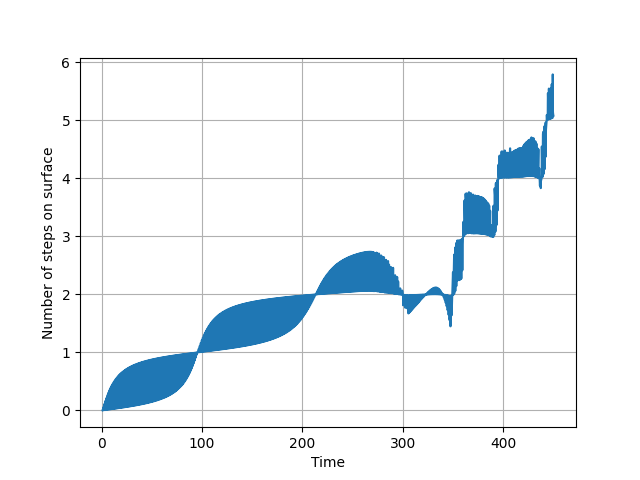

In [12]:
#print number of steps over time
Ntot = ss_1d.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0],maxes-mins)
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()

In [ ]:
#plot 
#cmpltion = 0.005 
cmpltion = 0.1

#for cmpltion in map(lambda x: x*3,[0,0.001,0.005]): # making plots of initial noise dissipating
ss_1d.plot(completion=cmpltion, ice=True, figurename=my_filename+'_completion'+str(cmpltion))
plt.savefig(my_filename+'_completion'+str(cmpltion)+'.png')
plt.close()


In [ ]:
#test_2d_asym.save(id=['asymmetric'+str(test_2d_asym.shape[0])+'_'+str(test_2d_asym.shape[1]),str(test_2d_asym.layermax)+'layers'])
#symm = Simulation(f2d,(500,500),rtol=1e-12)

In [ ]:
#countour plot of sigmastep 2d
plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'y ($\mu m$)')
#ax.set_zlabel('Layers of ice')
#levels = np.arange(19,21,0.1)
ax.contourf(xgrid,ygrid, sigma*100, extent=(0, 2, 0, 2), cmap='YlGnBu_r', vmin=0, vmax=200, zorder=1)#, levels=levels)

In [ ]:
#countour plot of sigmastep 2d
print(xs.shape,ys.shape,sigma.shape)
fig,ax = plt.subplots()
CS = ax.contourf(xs.T,ys.T,sigma*100)
ax.set_xlabel(r'$x (\mu m)$', fontsize=20)
ax.set_ylabel(r'$y (\mu m)$', fontsize=20)
plt.grid(True)
plt.gca().set_aspect('equal')
fig.colorbar(CS)
plt.title('%supersaturation (getsigmastep_2d)')

2D Growth simulation

In [ ]:
#create the 2d sim
test_f2d_sim = Simulation(f2d, (250,250), rtol=1e-12)
test_f2d_sim.layermax = 50#0
#test_f2d_sim.run()
#test_f2d_sim.save(_id=['test','50layer'])

In [ ]:
#animate the 2d sim
test_f2d_sim.animate(crossSection=True)

In [ ]:
#print variables in 1d simulation for comparison to literature
for k,v in test_f2d_sim._extra_vars.items():
    print(k,v)
print('center reduction %: ', test_f2d_sim.center_reduction)

In [ ]:
#print number of steps over time
Ntot = test_f2d_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0,0],maxes-mins)
#ax.plot(test_f2d_sim.results()['t'],test_f2d_sim.results()['t'])
plt.grid()

In [ ]:
#animate test_f2d_sim

test_f2d_sim.animate(ice=True)

In [ ]:
#test_f2d_sim = loadSim('f2d_simulation_test_50layer.pkl') 

In [ ]:
#graph results normalized to minimum of ice surface
Fliq_ss, Ntot_steadystate = test_f2d_sim.normalize_results_to_min()
nice_ss = Ntot_steadystate-Fliq_ss
print(np.shape(Ntot_steadystate))
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection = '3d')
#ax.plot_surface(test_f2d_sim._results['t'], Ntot_steadystate[:,])
ax.set_xlabel(r'$x (\mu m$)')#,fontsize=fontsize)
ax.set_ylabel(r'$y (\mu m$)')#,fontsize=fontsize)
ax.set_zlabel(r'$ice \ layers$')#,fontsize=fontsize)
#limits
#ax.set_zlim3d(-self.layermax, self.layermax)
#ax.set_ylim(0, max(self.y))
#ax.set_xlim(0, max(self.x))
def update_fig(num):
    ax.clear() # remove last iteration of plot 
    plot_func = ax.plot_surface
    # if crossSection:
    #     xmid = round(np.shape(Nice)[0]/2)
    #     if ice:
    #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=nice_ss[num][xmid:][:],cmap ='viridis')# cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice
    #     if tot:
    #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=Ntot_steadystate[num][xmid:][:], cmap='cividis')#, vmin=0, vmax=200) #plot half the surface of the QLL
    # else:
    #     if ice:
    plot_func(X=xs, Y=ys, Z=nice_ss[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
        # if tot:
    # plot_func(X=xs, Y=ys, Z=Ntot_steadystate[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
    pass


num_steps = len(test_f2d_sim._results['t'])
import matplotlib.animation as animation
ani = animation.FuncAnimation(fig , update_fig, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
plt.show()

In [ ]:
#graph difference in steps over time: should converge to zero if steady state is reached
Fliq_ss, Ntot_steadystate = test_f2d_sim.steady_state_calc()
nice_ss = Ntot_steadystate-Fliq_ss
print(np.shape(Ntot_steadystate))
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection = '3d')
#ax.plot_surface(test_f2d_sim._results['t'], Ntot_steadystate[:,])
ax.set_xlabel(r'$x (\mu m$)')#,fontsize=fontsize)
ax.set_ylabel(r'$y (\mu m$)')#,fontsize=fontsize)
ax.set_zlabel(r'$ice \ layers$')#,fontsize=fontsize)
#limits
#ax.set_zlim3d(-self.layermax, self.layermax)
#ax.set_ylim(0, max(self.y))
#ax.set_xlim(0, max(self.x))
def update_fig(num):
    ax.clear() # remove last iteration of plot 
    plot_func = ax.plot_surface
    # if crossSection:
    #     xmid = round(np.shape(Nice)[0]/2)
    #     if ice:
    #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=nice_ss[num][xmid:][:],cmap ='viridis')# cmap='viridis')#, vmin=0, vmax=200) #plot half of the surface of the ice
    #     if tot:
    #         plot_func(X=xs[xmid:], Y=ys[xmid:], Z=Ntot_steadystate[num][xmid:][:], cmap='cividis')#, vmin=0, vmax=200) #plot half the surface of the QLL
    # else:
    #     if ice:
    plot_func(X=xs, Y=ys, Z=nice_ss[num], cmap='viridis')#, vmin=0, vmax=200) #plot the surface of the ice 
        # if tot:
    # plot_func(X=xs, Y=ys, Z=Ntot_steadystate[num], cmap='YlGnBu_r')#, vmin=0, vmax=200)#plot the surface of the QLL
    pass


num_steps = len(test_f2d_sim._results['t'])
import matplotlib.animation as animation
ani = animation.FuncAnimation(fig , update_fig, num_steps, interval=50, blit=False, cache_frame_data=False, repeat = True)
plt.show()

In [ ]:
test_2d_sim = Simulation(f2d, (500,500), rtol=1e-12)
test_2d_sim.layermax = 2
#test_2d_sim = loadSim('f2d_simulation_august13.pkl')
_plot = test_2d_sim.plot()

1d simulation 

In [ ]:
test_2d_sim.save(id=['august13'])

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
num_steps = len(test_2d_sim.results()['t'])
xs,ys = np.meshgrid(test_2d_sim.x, test_2d_sim.y)
ax.plot_surface(X=xs, Y=ys, Z=test_2d_sim.getNtot()[num_steps-1], cmap='viridis')

In [ ]:
test_1d = Simulation(f1d, shape=(500,), rtol=1e-12)
test_1d.layermax = 500
test_1d.results()

In [ ]:
#test_1d.animate(ice=True, tot=True)
test_1d.plot()

2d Idea: increase sigmastepmax to see if faceted growth occur, removing the concave "bowl" forming at the center of initially tested 2d systems (test_f2d_sim)

In [ ]:
# sigma_test = Simulation(f2d, (500,500),rtol = 1e-12)
# sigma_test.layermax = 100
# sigma_test.sigmastepmax = 0.25
# sigma_test.results()

In [ ]:
#sigma_id = ['sigmastepmax_'+str(round(100*sigma_test.sigmastepmax)), str(sigma_test.layermax)+'layers']
#sigma_test.save(id=sigma_id)

#test increased layers with increased sigmastep

#sigma_test = loadSim('f2d_simulation_sigmastepmax_025.pkl') # 20 layers?
#sigma_test = loadSim('f2d_simulation_sigmastepmax_025_50layers.pkl')
sigma_test = loadSim('f2d_simulation_sigmastepmax_25_100layers.pkl')

In [ ]:
sigma_test.animate()

2d Ablation testing

In [ ]:
f2d_ablate = Simulation(f2d, (500,500), rtol=1e-12)
f2d_ablate.sigmastepmax = -0.1
f2d_ablate.layermax = 50
f2d_ablate.animate()

1d growth testing. Works, however does not currently match the literature graph despite using the same parameters.

In [ ]:
f1d_sim = Simulation(f1d, (500,), rtol=1e-12)

In [ ]:
#change parameters to match Gladich et al paper's graph and run simulation
f1d_sim.layermax = 500#10000
#f1d_sim.center_reduction = 0.25 #is default now

In [ ]:
f1d_sim.run()

In [ ]:
fig = f1d_sim.plot(completion=0.99, ice=True, tot=True)

In [ ]:
#print variables in 1d simulation for comparison to literature
for k,v in f1d_sim._extra_vars.items():
    print(k,v)
print('center reduction %: ', f1d_sim.center_reduction)

In [ ]:
#functions tested so far
#test_f2d_sim.countermax_0D
#test_f2d_sim.countermax_1D
#test_f2d_sim.countermax_2D
#test_f2d_sim.atol
#test_f2d_sim.rtol
#test_f2d_sim.deltaT
#test_f2d_sim.float_params
#test_f2d_sim.animate()
#test_f2d_sim.run()
#test_f2d_sim.steady_state_calc()
#test_f2d_sim.plot()
#test_f2d_sim.save()
#test_f2d_sim.load() #WORKS to load simulation from file if simulation object exists already -- for loading straght froom file use loadSim()
#loadSim() #works



In [ ]:
num_steps = len(test_f2d_sim.results()['t'])
#shape of results is (num_steps, 2, nx, ny)
Fliq, Ntot = [],[]
for step in range(num_steps):
    next_Fliq, next_Ntot = test_f2d_sim._results['y'][step]
    Fliq.append(next_Fliq)
    Ntot.append(next_Ntot)    
Fliq,Ntot = np.array(Fliq), np.array(Ntot)
Nice = Ntot - Fliq
#shape of fliq, ntot and nice should be (num_steps, nx, ny)

#access coordinate arrays for plotting
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

In [ ]:
print(num_steps)
print(test_f2d_sim.steepness(0,slice(0,test_f2d_sim.shape[0]//2)))

In [ ]:
print(test_f2d_sim.get_step_density(0,slice(0,test_f2d_sim.shape[0]//2)))  